## Importing the dependencies

In [1]:
# For data manipulation and processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# For data processing
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# For neural network training
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense

print("Everything imported successfully !")

Everything imported successfully !


In [2]:
# Let's load the dataset into dataframe
df = pd.read_csv('data.csv',parse_dates=['DATE'])

## Exploratory data analysis

In [3]:
# Let's check the shape of the dataframe and any 5 random rows
print("Shape :",df.shape)
df.sample(5)

Shape : (25551, 5)


,DATE,PRCP,TMAX,TMIN,RAIN
20294,2003-07-25,0.00,77,53,False
19964,2002-08-29,0.00,75,54,False
6701,1966-05-07,0.00,67,47,False
12935,1983-06-01,0.01,58,52,True
22272,2008-12-23,0.00,35,29,False


In [4]:
# Let's get some basic information about our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    25551 non-null  datetime64[ns]
 1   PRCP    25548 non-null  float64       
 2   TMAX    25551 non-null  int64         
 3   TMIN    25551 non-null  int64         
 4   RAIN    25548 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 998.2+ KB


- There are very few missing values in teh PRCP and RAIN feature.

In [5]:
type(df['RAIN'].iloc[0])

bool

DATE    0.000000
PRCP    0.011741
TMAX    0.000000
TMIN    0.000000
RAIN    0.011741
dtype: float64


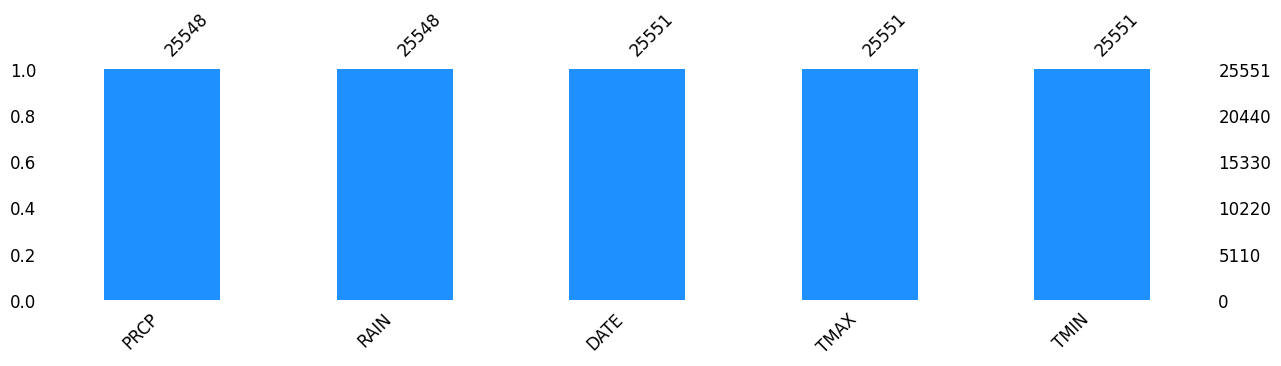

In [6]:
# Let's get percentage of missing values and visualize them
print(df.isnull().mean()*100)

# Visualizing missing values
msno.bar(df, figsize=(15, 3), color="dodgerblue", sort="ascending", fontsize=12)
plt.show()

In [7]:
# Let's see if there are any duplicate values
print("Total duplicate values :",df.duplicated().sum())

Total duplicate values : 0


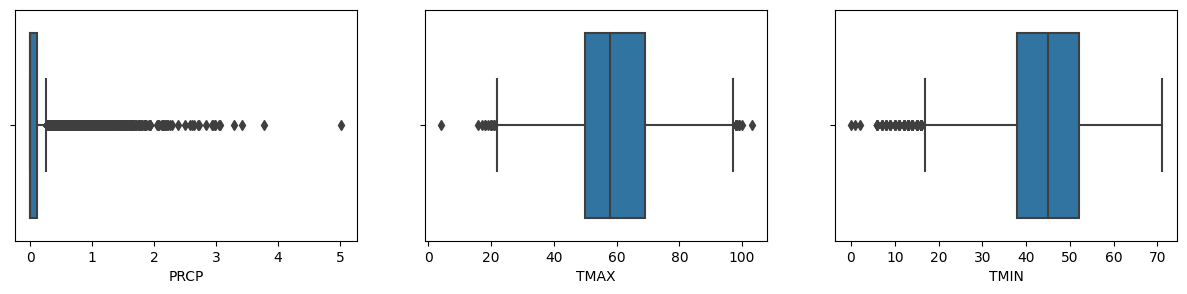

In [8]:
# Let's see if there are any outliers
fig,ax = plt.subplots(1,3,figsize=(15,3))

sns.boxplot(x = df['PRCP'],ax = ax[0])
sns.boxplot(x = df['TMAX'],ax = ax[1])
sns.boxplot(x = df['TMIN'],ax = ax[2])

plt.show()

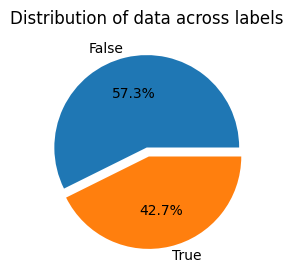

In [9]:
# Plot a pie chart to see class distribution
fig, ax = plt.subplots(figsize=(3, 3))

ex = [0.0, 0.1]
plt.pie(
    df["RAIN"].value_counts(),
    labels= df["RAIN"].value_counts().index,
    autopct="%1.1f%%",
    explode=ex,
)
plt.title("Distribution of data across labels")
plt.show()

## Data cleaning and processing

In [10]:
# Let's first create some new feature by extracting date, month and year from DATE feature
df['month'] = df['DATE'].dt.month
df['year'] = df['DATE'].dt.year
df['week'] = df['DATE'].dt.isocalendar().week

In [11]:
# Let's drop the DATE column
df.drop(['DATE'],axis = 1,inplace=True)

Since the percentage of missing values are very much small, so we can either remove or impute the missing values. But before
imputing the missing values we need to deal with outliers because outliers can significantly affect the mean.

In the feature PRCP there are lot of outliers so simply removing them will make our dataset very much thin and capping them will change the distribution of that feature, so instead of using these techniques we will transform the values present in this feature using Box-Cox transformation.

In [12]:
# Let's create a copy to experiment
temp_df = df.copy()

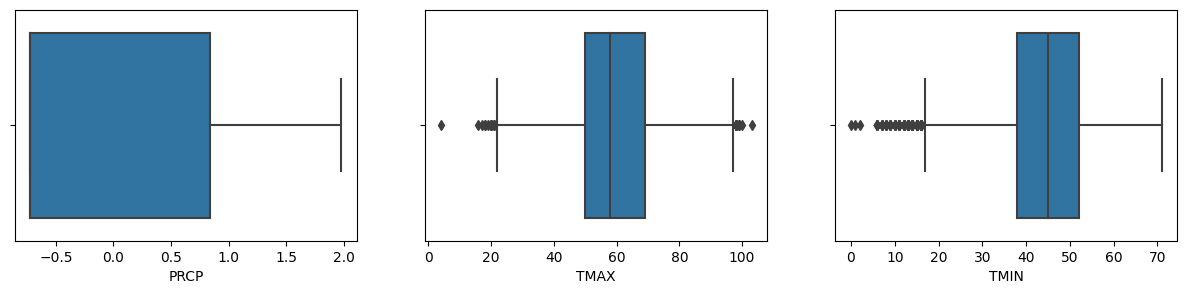

In [13]:
# Instantiating the
pt = PowerTransformer()

temp_df['PRCP'] = pt.fit_transform(temp_df['PRCP'].values.reshape(-1,1)).reshape(-1)

fig,ax = plt.subplots(1,3,figsize=(15,3))

sns.boxplot(x = temp_df['PRCP'],ax = ax[0])
sns.boxplot(x = temp_df['TMAX'],ax = ax[1])
sns.boxplot(x = temp_df['TMIN'],ax = ax[2])

plt.show()

For the year we need to nominal encoding, so for the complete data processing we will be building a pipeline that will streamline this process.

In [14]:
rain_imp = SimpleImputer(strategy="most_frequent")
df['RAIN'] = rain_imp.fit_transform(df['RAIN'].values.reshape(-1,1)).reshape(-1)

In [15]:
# Replacing True with 0 and False with 1
for i in range(len(df)):
  item = df['RAIN'].iloc[i]
  df.loc[i, 'RAIN'] = int(item)

df['RAIN'] = df['RAIN'].astype(np.int32)

In [16]:
yeo_john_transformation = ColumnTransformer(transformers=[
    ('Yeo_johnson_transformation',PowerTransformer(),[0])
],remainder='passthrough')

missing_value_imputer = ColumnTransformer(transformers=[
    ('Mean_imputation', SimpleImputer(strategy="mean"),[0])
],remainder='passthrough')

nominal_encoding = ColumnTransformer(transformers=[
    ('Target_encode_year',ce.TargetEncoder(smoothing=0.2, handle_missing="return_nan"),[4])
],remainder='passthrough')

feature_scaling = ColumnTransformer(transformers=[
    ('Feature_scaling',MinMaxScaler(),[0,1,2,3,4,5])
],remainder='passthrough')

# Let's build a pipeline
pipe = Pipeline(
    steps=[
        ("Yeo-Johnson-Transformation", yeo_john_transformation),
        ("Nan_Imptation", missing_value_imputer),
        ("Encoding",nominal_encoding),
        ("Scaling", feature_scaling)
    ]
)

In [17]:
# Seperating the data into dependent and independnet variable
X = df.drop(["RAIN"], axis=1)
y = df["RAIN"]

# Let's split the data into train,test and validation for data processing
X_train,X_test_val_data,y_train,y_test_val_data = train_test_split(X,y, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val_data,y_test_val_data, test_size=0.5, random_state=42)

In [18]:
# Let's process the training data
X_train = pipe.fit_transform(X_train,y_train)
X_train_df = pd.DataFrame(X_train,columns = ['Year','PRCP','TMAX','TMIN','Month','Week'])

In [19]:
# Just for sake of heatmap we are combining adding y_train in X_train_df
X_train_df['Target'] = y_train

<Axes: >

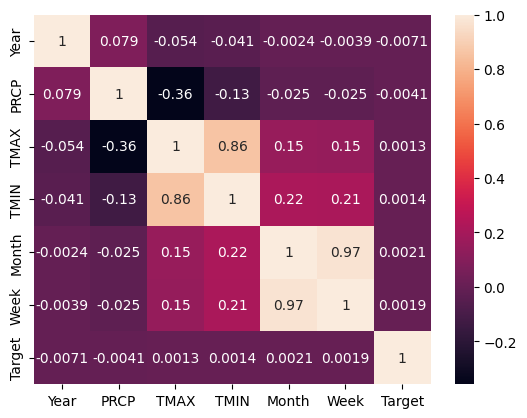

In [20]:
# Let's see correlation
sns.heatmap(X_train_df.corr(),annot=True)

Since year, month and week are not having strong positive or negative correlation with Target so we can remove them, but let's train the model including them.

## Loading the Numpy arrays into tf.data.Dataset

In [21]:
# Let's first convert the series to numpy array
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)

# Process the testing data
X_test = pipe.transform(X_test)
X_val = pipe.transform(X_val)

#Converting numpy array to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train)
y_train = tf.convert_to_tensor(y_train)
X_test = tf.convert_to_tensor(X_test)
y_test = tf.convert_to_tensor(y_test)
X_val = tf.convert_to_tensor(X_val)
y_val = tf.convert_to_tensor(y_val)

In [22]:
# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

# Set the batch size and shuffle the data
train_dataset = train_dataset.batch(32).shuffle(True).repeat()
test_dataset = test_dataset.batch(32).shuffle(True).repeat()
val_dataset = val_dataset.batch(32).shuffle(True).repeat()

In [ ]:
# iter will help us to iterate over tensorflow dataset in form of batches
train_loader = iter(train_dataset)
test_loader = iter(test_dataset)
val_loader = iter(val_dataset)

## Building neural network for training
For building a neural network which gives us best result can be tedious if we will use the hit and trial method for deciding the below mentioned hyper parameters 

- Number of hiddne layers
- Number of neurons per layer
- Activation function
- Optimizer

In [ ]:
def build_model(hp):

    model = Sequential(layers = [
        Dense(units = )
    ])
    

In [48]:
# Building a model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(50, activation='relu', input_shape=(6,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compiling the model
model.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics =['accuracy'])

Steps per Epoch: The number of steps per epoch is determined by dividing the total number of samples in the training dataset by the batch size. It tells the model how many times it should update its parameters (weights and biases) within one epoch. The formula for calculating the steps per epoch is:se:

steps_per_epoch = 20448 // 32 = 639

In [49]:
# Train your model using the iterators
model.fit(train_loader, steps_per_epoch=639, epochs=10, validation_data=val_loader, validation_steps=80)

Epoch 1/10
639/639 [==============================] - 6s 9ms/step - loss: 0.3328 - accuracy: 0.8773 - val_loss: 0.1774 - val_accuracy: 0.9390
Epoch 2/10
639/639 [==============================] - 5s 8ms/step - loss: 0.1223 - accuracy: 0.9554 - val_loss: 0.1000 - val_accuracy: 0.9613
Epoch 3/10
639/639 [==============================] - 5s 8ms/step - loss: 0.0721 - accuracy: 0.9683 - val_loss: 0.0612 - val_accuracy: 0.9855
Epoch 4/10
639/639 [==============================] - 5s 8ms/step - loss: 0.0446 - accuracy: 0.9868 - val_loss: 0.0374 - val_accuracy: 0.9996
Epoch 5/10
639/639 [==============================] - 5s 8ms/step - loss: 0.0274 - accuracy: 0.9988 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 6/10
639/639 [==============================] - 5s 8ms/step - loss: 0.0167 - accuracy: 0.9999 - val_loss: 0.0132 - val_accuracy: 1.0000
Epoch 7/10
639/639 [==============================] - 5s 8ms/step - loss: 0.0104 - accuracy: 0.9999 - val_loss: 0.0080 - val_accuracy: 1.0000
Epoch 

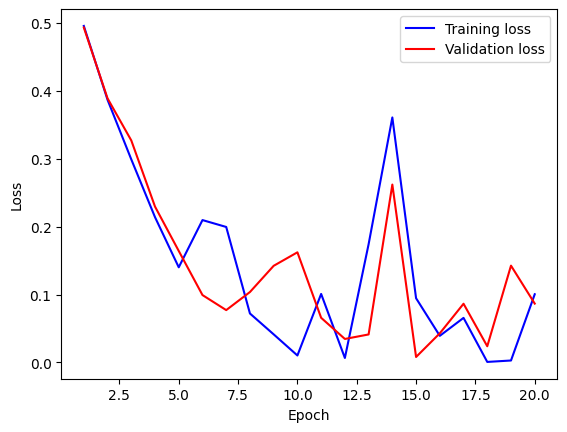

In [ ]:
# Plot the loss
plt.plot(range(1, len(loss_list) + 1), loss_list, 'blue', label='Training loss')
plt.plot(range(1, len(valloss_list) + 1), valloss_list, 'red', label='Validation loss')

# Label the axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Show the graph
plt.show()


In [ ]:
# Evaluate the model
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(torch.float32)
        y_batch = y_batch.unsqueeze(1)
        y_batch = y_batch.float()
        output = model(x_batch)
        loss = loss_function(output, y_batch)
    print(loss)

tensor(0.0006)
